### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл)

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import grad

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator()
discriminator = Discriminator()

In [11]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [12]:
input = torch.FloatTensor(config.batch_size, 28*28)
noise = torch.FloatTensor(config.batch_size, config.noise_size)
fixed_noise = torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)
label = torch.FloatTensor(config.batch_size)
real_label = 1
fake_label = 0

In [13]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label.view(16, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label.view(16, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label.view(16, 1))
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.32 errD_z: 0.12 errG: 2.24
Epoch:1 Iter: 200 errD_x: 0.60 errD_z: 0.16 errG: 2.40
Epoch:1 Iter: 300 errD_x: 0.19 errD_z: 0.14 errG: 2.34
Epoch:1 Iter: 400 errD_x: 0.21 errD_z: 0.13 errG: 2.32
Epoch:1 Iter: 500 errD_x: 0.08 errD_z: 0.15 errG: 2.10
Epoch:1 Iter: 600 errD_x: 0.04 errD_z: 0.13 errG: 2.22
Epoch:1 Iter: 700 errD_x: 0.27 errD_z: 0.11 errG: 2.51
Epoch:1 Iter: 800 errD_x: 0.03 errD_z: 0.05 errG: 3.11
Epoch:1 Iter: 900 errD_x: 0.17 errD_z: 0.11 errG: 2.57
Epoch:1 Iter: 1000 errD_x: 0.01 errD_z: 0.31 errG: 1.54
Epoch:1 Iter: 1100 errD_x: 0.25 errD_z: 0.16 errG: 2.03
Epoch:1 Iter: 1200 errD_x: 0.13 errD_z: 0.18 errG: 2.02
Epoch:1 Iter: 1300 errD_x: 0.21 errD_z: 0.11 errG: 2.40
Epoch:1 Iter: 1400 errD_x: 0.20 errD_z: 0.23 errG: 1.96
Epoch:1 Iter: 1500 errD_x: 0.18 errD_z: 0.24 errG: 1.85
Epoch:1 Iter: 1600 errD_x: 0.16 errD_z: 0.22 errG: 2.14
Epoch:1 Iter: 1700 errD_x: 0.19 errD_z: 0.17 errG: 2.28
Epoch:1 Iter: 1800 errD_x: 0.33 errD_z: 0.18 errG: 2.43
E

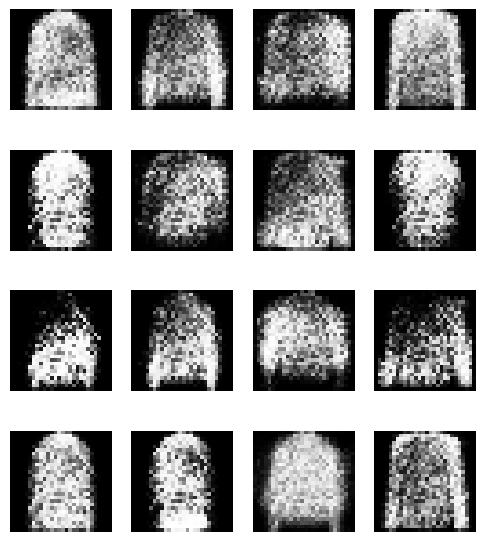

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

# Задание 1. Реализация WGAN

In [15]:
class Generator_WGAN(nn.Module):
    def __init__(self):
        super(Generator_WGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class Critic_WGAN(nn.Module):
    def __init__(self):
        super(Critic_WGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)


generator = Generator_WGAN()
discriminator = Critic_WGAN()

In [16]:
optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optim_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)

noise = torch.FloatTensor(config.batch_size, config.noise_size)
fixed_noise = torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)

ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)

In [17]:
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, _) in enumerate(dataloader):
        discriminator.zero_grad()

        real_data = images.view(images.size(0), -1)
        real_data = real_data.to(torch.float32)

        noise.data.normal_(0, 1)
        fake_data = generator(noise)

        D_real = discriminator(real_data)
        D_fake = discriminator(fake_data.detach())

        # WGAN loss для Дискриминатора: D(fake) - D(real)
        loss_D = D_fake.mean() - D_real.mean()
        loss_D.backward()
        optim_D.step()

        # Клиппинг весов дискриминатора
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        ERRD[epoch] += loss_D.item()

        generator.zero_grad()

        fake_data = generator(noise)
        D_fake_for_G = discriminator(fake_data)

        loss_G = -D_fake_for_G.mean()
        loss_G.backward()
        optim_G.step()

        ERRG[epoch] += loss_G.item()

        if (iteration + 1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} loss_D: {:.4f} loss_G: {:.4f}'.format(epoch + 1,
                                                                           iteration + 1,
                                                                           loss_D.item(),
                                                                           loss_G.item()))

    # Нормализация ошибок за эпоху
    ERRD[epoch] /= N
    ERRG[epoch] /= N

Epoch:1 Iter: 100 loss_D: -0.0827 loss_G: 0.0521
Epoch:1 Iter: 200 loss_D: -0.1773 loss_G: 0.1288
Epoch:1 Iter: 300 loss_D: -0.1436 loss_G: 0.1912
Epoch:1 Iter: 400 loss_D: -0.1647 loss_G: 0.2117
Epoch:1 Iter: 500 loss_D: -0.1375 loss_G: 0.2081
Epoch:1 Iter: 600 loss_D: -0.1035 loss_G: 0.2035
Epoch:1 Iter: 700 loss_D: -0.0963 loss_G: 0.1602
Epoch:1 Iter: 800 loss_D: -0.1042 loss_G: 0.0725
Epoch:1 Iter: 900 loss_D: -0.1030 loss_G: 0.0565
Epoch:1 Iter: 1000 loss_D: -0.1423 loss_G: 0.0186
Epoch:1 Iter: 1100 loss_D: -0.1039 loss_G: 0.0087
Epoch:1 Iter: 1200 loss_D: -0.0982 loss_G: -0.0233
Epoch:1 Iter: 1300 loss_D: -0.1455 loss_G: -0.0140
Epoch:1 Iter: 1400 loss_D: -0.1139 loss_G: -0.0568
Epoch:1 Iter: 1500 loss_D: -0.0828 loss_G: -0.0343
Epoch:1 Iter: 1600 loss_D: -0.1160 loss_G: -0.0751
Epoch:1 Iter: 1700 loss_D: -0.0416 loss_G: -0.0838
Epoch:1 Iter: 1800 loss_D: -0.1273 loss_G: -0.0069
Epoch:1 Iter: 1900 loss_D: -0.1009 loss_G: -0.0301
Epoch:1 Iter: 2000 loss_D: -0.0540 loss_G: -0.0694


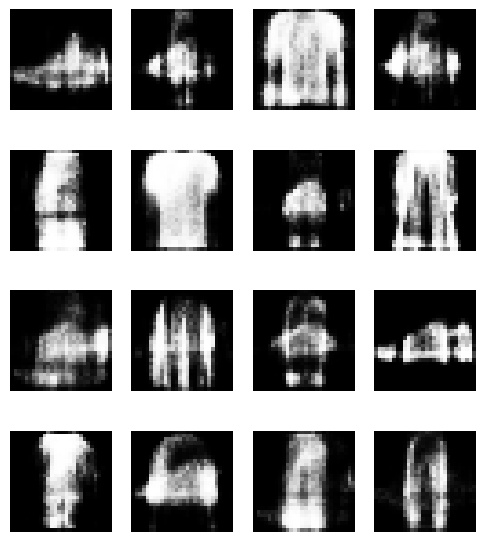

In [18]:
noise.data.normal_(0, 1)
fake_samples = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_samples[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()


На сгенерированных картинках угадывается форма некоторых предметов одежды

# Задание 2. Реализация Gradient penalty

In [19]:
config.lambda_gp = 10.0  # Коэффициент для градиентного штрафа

class Generator_GP(nn.Module):
    def __init__(self):
        super(Generator_GP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator_GP(nn.Module):
    def __init__(self):
        super(Discriminator_GP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)


generator = Generator_GP()
discriminator = Discriminator_GP()

In [20]:
optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optim_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)

noise = torch.FloatTensor(config.batch_size, config.noise_size)
fixed_noise = torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)

ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

In [21]:
# Функция для расчёта градиентного штрафа
def gradient_penalty(critic, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1)
    alpha = alpha.expand(real_data.size()).contiguous()
    alpha = alpha.to(real_data.device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.detach().requires_grad_(True)

    disc_interpolates = critic(interpolates)

    ones = torch.ones(disc_interpolates.size()).to(real_data.device)

    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=ones,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    # Штраф (||grad||2 - 1)^2
    gp = ((gradient_norm - 1) ** 2).mean() * config.lambda_gp
    return gp

In [22]:
for epoch in range(config.num_epochs):
    for iteration, (images, _) in enumerate(dataloader):
        real_data = images.view(images.size(0), -1).float()

        discriminator.zero_grad()

        noise.data.normal_(0, 1)
        fake_data = generator(noise)

        D_real = discriminator(real_data)
        D_fake = discriminator(fake_data.detach())

        gp = gradient_penalty(discriminator, real_data, fake_data.detach())

        loss_D = D_fake.mean() - D_real.mean() + gp
        loss_D.backward()
        optim_D.step()

        ERRD[epoch] += loss_D.item()

        generator.zero_grad()
        fake_data = generator(noise)
        D_fake_for_G = discriminator(fake_data)

        loss_G = -D_fake_for_G.mean()
        loss_G.backward()
        optim_G.step()

        ERRG[epoch] += loss_G.item()

        if (iteration + 1) % config.print_freq == 0:
            print(f'Epoch:{epoch + 1} Iter: {iteration + 1} loss_D: {loss_D.item():.4f} loss_G: {loss_G.item():.4f}')

    ERRD[epoch] /= N
    ERRG[epoch] /= N

Epoch:1 Iter: 100 loss_D: -2.9242 loss_G: 2.3112
Epoch:1 Iter: 200 loss_D: -3.9639 loss_G: 4.6536
Epoch:1 Iter: 300 loss_D: -4.5494 loss_G: 6.2653
Epoch:1 Iter: 400 loss_D: -3.2557 loss_G: 6.9000
Epoch:1 Iter: 500 loss_D: -3.1766 loss_G: 5.4845
Epoch:1 Iter: 600 loss_D: -2.9237 loss_G: 3.6082
Epoch:1 Iter: 700 loss_D: -2.3311 loss_G: 2.4298
Epoch:1 Iter: 800 loss_D: -2.3345 loss_G: 0.6094
Epoch:1 Iter: 900 loss_D: -3.1814 loss_G: 0.3906
Epoch:1 Iter: 1000 loss_D: -2.8123 loss_G: -0.2236
Epoch:1 Iter: 1100 loss_D: -3.2745 loss_G: 0.2095
Epoch:1 Iter: 1200 loss_D: -2.8657 loss_G: -0.4424
Epoch:1 Iter: 1300 loss_D: -2.1116 loss_G: -0.3002
Epoch:1 Iter: 1400 loss_D: -3.1822 loss_G: -0.5876
Epoch:1 Iter: 1500 loss_D: -3.4380 loss_G: -0.4034
Epoch:1 Iter: 1600 loss_D: -2.5531 loss_G: -1.4827
Epoch:1 Iter: 1700 loss_D: -3.4355 loss_G: -1.3500
Epoch:1 Iter: 1800 loss_D: -3.1261 loss_G: -0.5631
Epoch:1 Iter: 1900 loss_D: -3.7578 loss_G: -0.8329
Epoch:1 Iter: 2000 loss_D: -2.2192 loss_G: -1.3783

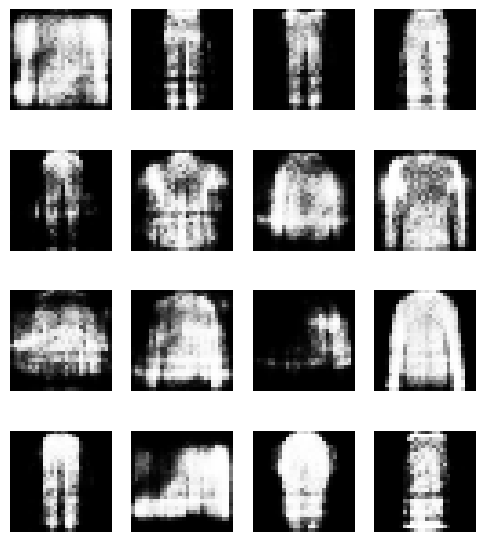

In [23]:
noise.data.normal_(0, 1)
fake_samples = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_samples[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()


Здесь, как будто, формы предметов одежды более чёткие, чем в предыдущем задании.

# Задание 3. Реализуем генерацию по метке

In [24]:
config.lambda_gp = 10.0  # Коэффициент для градиентного штрафа
config.num_classes = 10  # FashionMNIST классы от 0 до 9
config.image_dim = 28 * 28

In [25]:
# Функция one-hot
def one_hot(labels, num_classes=10):
    y_one_hot = torch.zeros(labels.size(0), num_classes)
    y_one_hot[torch.arange(labels.size(0)), labels] = 1
    return y_one_hot


class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        # Теперь вход размером noise_size + num_classes
        input_dim = config.noise_size + config.num_classes
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, config.image_dim),
            nn.Sigmoid()
        )

    def forward(self, z, y_onehot):
        # Конкатенация шума и one-hot вектора
        input_vec = torch.cat([z, y_onehot], dim=1)
        return self.model(input_vec)


class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        input_dim = config.image_dim + config.num_classes
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )

    def forward(self, x, y_onehot):
        input_vec = torch.cat([x, y_onehot], dim=1)
        return self.model(input_vec)


generator = ConditionalGenerator()
critic = ConditionalDiscriminator()

optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optim_D = optim.RMSprop(critic.parameters(), lr=0.00005)

noise = torch.FloatTensor(config.batch_size, config.noise_size)
fixed_noise = torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)

ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

In [26]:
def gradient_penalty(critic, real_data, fake_data, real_labels):
    y_onehot = one_hot(real_labels, config.num_classes)
    alpha = torch.rand(real_data.size(0), 1)
    alpha = alpha.expand(real_data.size()).contiguous()

    alpha = alpha.to(real_data.device)
    y_onehot = y_onehot.to(real_data.device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.detach().requires_grad_(True)

    disc_interpolates = critic(interpolates, y_onehot)

    ones = torch.ones(disc_interpolates.size()).to(real_data.device)

    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=ones,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean() * config.lambda_gp
    return gp


for epoch in range(config.num_epochs):
    for iteration, (images, labels) in enumerate(dataloader):
        real_data = images.view(images.size(0), -1).float()
        batch_size = real_data.size(0)

        # Перезапись noise и меток под текущий batch size
        if batch_size != config.batch_size:
            noise = torch.FloatTensor(batch_size, config.noise_size)
        noise.data.normal_(0, 1)

        # One-hot для реальных меток
        real_y = one_hot(labels, config.num_classes)
        real_y = real_y.to(real_data.device)
        real_data = real_data.to(real_data.device)
        noise = noise.to(real_data.device)

        fake_data = generator(noise, real_y)

        critic.zero_grad()

        D_real = critic(real_data, real_y)
        D_fake = critic(fake_data.detach(), real_y)

        gp = gradient_penalty(critic, real_data, fake_data.detach(), labels)
        loss_D = D_fake.mean() - D_real.mean() + gp
        loss_D.backward()
        optim_D.step()

        ERRD[epoch] += loss_D.item()

        generator.zero_grad()
        fake_data = generator(noise, real_y)
        D_fake_for_G = critic(fake_data, real_y)
        loss_G = -D_fake_for_G.mean()
        loss_G.backward()
        optim_G.step()

        ERRG[epoch] += loss_G.item()

        if (iteration + 1) % config.print_freq == 0:
            print(f'Epoch:{epoch + 1} Iter: {iteration + 1} loss_D: {loss_D.item():.4f} loss_G: {loss_G.item():.4f}')

    ERRD[epoch] /= N
    ERRG[epoch] /= N

Epoch:1 Iter: 100 loss_D: -3.5331 loss_G: 2.2953
Epoch:1 Iter: 200 loss_D: -4.5342 loss_G: 4.0999
Epoch:1 Iter: 300 loss_D: -4.2446 loss_G: 5.9721
Epoch:1 Iter: 400 loss_D: -3.1429 loss_G: 6.9514
Epoch:1 Iter: 500 loss_D: -3.2868 loss_G: 5.5045
Epoch:1 Iter: 600 loss_D: -3.1762 loss_G: 2.7688
Epoch:1 Iter: 700 loss_D: -3.9622 loss_G: 1.5875
Epoch:1 Iter: 800 loss_D: -3.4559 loss_G: -0.2052
Epoch:1 Iter: 900 loss_D: -3.2269 loss_G: -0.2022
Epoch:1 Iter: 1000 loss_D: -3.0658 loss_G: -0.2818
Epoch:1 Iter: 1100 loss_D: -4.1938 loss_G: -0.5005
Epoch:1 Iter: 1200 loss_D: -3.5062 loss_G: -0.3885
Epoch:1 Iter: 1300 loss_D: -3.6380 loss_G: -0.5458
Epoch:1 Iter: 1400 loss_D: -3.5841 loss_G: -0.9525
Epoch:1 Iter: 1500 loss_D: -3.8161 loss_G: -0.4782
Epoch:1 Iter: 1600 loss_D: -4.4864 loss_G: -1.1314
Epoch:1 Iter: 1700 loss_D: -3.7984 loss_G: -0.8618
Epoch:1 Iter: 1800 loss_D: -3.5298 loss_G: -1.2746
Epoch:1 Iter: 1900 loss_D: -2.8135 loss_G: -1.6209
Epoch:1 Iter: 2000 loss_D: -3.3155 loss_G: -0.2

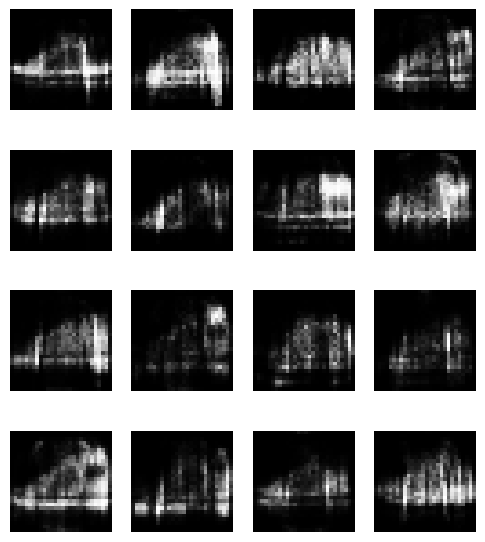

In [27]:
# Генерируем ботинки
class_id = 5
test_labels = torch.tensor([class_id] * config.batch_size)
test_y = one_hot(test_labels, config.num_classes)
test_noise = torch.randn(config.batch_size, config.noise_size)
test_noise = test_noise.to(next(generator.parameters()).device)
test_y = test_y.to(test_noise.device)

fake_samples = generator(test_noise, test_y)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_samples[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

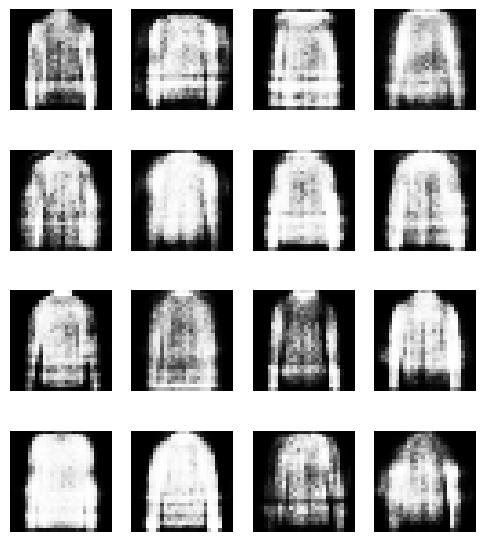

In [29]:
# Генерируем плащ
class_id = 4
test_labels = torch.tensor([class_id] * config.batch_size)
test_y = one_hot(test_labels, config.num_classes)
test_noise = torch.randn(config.batch_size, config.noise_size)
test_noise = test_noise.to(next(generator.parameters()).device)
test_y = test_y.to(test_noise.device)

fake_samples = generator(test_noise, test_y)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_samples[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

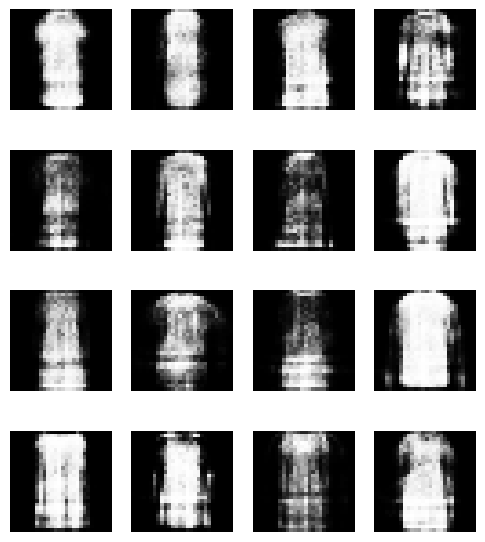

In [30]:
plt.show()
# Генерируем платье
class_id = 3
test_labels = torch.tensor([class_id] * config.batch_size)
test_y = one_hot(test_labels, config.num_classes)
test_noise = torch.randn(config.batch_size, config.noise_size)
test_noise = test_noise.to(next(generator.parameters()).device)
test_y = test_y.to(test_noise.device)

fake_samples = generator(test_noise, test_y)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_samples[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

Как можно заметить, генерируются именно те предметы гардероба, которые мы задаём с помощью метки. Значит идея работает.

### Выводы  
Удивительно, что даже такая простая и лёгкая нейросеть почти справилась с поставленной задачей. Кроме того, судя по сгенерированным картинкам, архитектура WGAN и использование Gradient Penalty повышает качества генерации довольно сильно.